## 0. Setup of the environment

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

scripts_path = os.path.abspath(os.path.join('helpers'))
if scripts_path not in sys.path:
    sys.path.insert(0,scripts_path)
from station_location import *

In [2]:
DATA_PATH = 'data/'
PROCESSED_DATA_PATH = 'processed-data'
TRUE_VALUES_PATHS = ['data/catalog_2017.csv', 
                     'data/catalog_2018.csv', 
                     'data/catalog_2019.csv']
ANTENNA_INDEX = 0
SPS = 100
START_TIME_INDEX = 3
TIME_WINDOW = 60
NUM_DAY_PER_DIR = 15

# The antenna we chose, as in the scripts
ANTENNA = ['GS', 'OK029', '00', 'HH1', 'M']

In [3]:
def get_timestamps(start_time, number_window):
    """
    Function useful to get a list of timestamps from a given start time.
    """
    times = [start_time + pd.to_timedelta(i * (total_window_size / SPS), unit='s') 
             for i in range(number_window)]
    return pd.Series(times)

## 1. Creation of the catalog of earthquakes

First we load the raw hand-made catalog

In [4]:
catalog = pd.DataFrame()
for ys in TRUE_VALUES_PATHS:
    new_catalog = pd.read_csv(ys)
    if 'depth' in new_catalog.columns:
        new_catalog.rename(columns={'depth': 'depth_km'}, inplace=True)
    catalog = catalog.append(new_catalog, sort=False) 
catalog = catalog.reset_index()
catalog["origintime"] = pd.to_datetime(catalog["origintime"])
catalog.sort_values("origintime", inplace=True)
catalog.head(5)

index       id                 origintime  latitude  longitude  depth_km  \
0      0  27287.0 2017-01-01 02:29:41.795999  35.25422  -97.76945     4.194   
1      1  27285.0 2017-01-01 06:43:01.465000  36.28558  -97.50169     4.179   
2      2  27278.0 2017-01-02 15:25:35.006000  36.39678  -96.88587     4.152   
3      3  27277.0 2017-01-02 15:28:40.168999  36.39613  -96.88583     4.241   
4      4  27001.0 2017-01-02 15:41:50.164000  36.30314  -97.53593     3.112   

   err_lon  err_lat  err_depth err_origintime  ...  \
0      0.5      0.4        0.9           0.31  ...   
1      0.4      0.3        0.9           0.37  ...   
2      0.3      0.2        0.4           0.32  ...   
3      0.4      0.3        0.6            0.4  ...   
4      0.3      0.3        0.9           0.36  ...   

                                             reafile  \
0  /home/analyst/REA/OGS__/2017/01/01-0228-56L.S2...   
1  /home/analyst/REA/OGS__/2017/01/01-0642-16L.S2...   
2  /home/analyst/REA/OGS__/2017/01/02-1524-49L.S2...   
3  /home/analyst/REA/OGS__/2017/01/02-1527-55L.S2...   
4  /home/analyst/REA/OGS__/2017/01/02-1541-15L.S2...   

                     reamtime  \
0   2017-01-27 21:31:51.28688   
1  2017-01-27 21:05:04.611471   
2  2017-01-27 20:11:43.272473   
3  2017-01-27 19:22:46.231692   
4  2017-01-12 17:05:31.794816   

                                                geom    pdlid mw_ogs  \
0  0101000020E6100000107A36AB3E7158C09BFEEC478AA0...  18702.0    NaN   
1  0101000020E6100000BCAE5FB01B6058C02332ACE28D24...  18704.0    NaN   
2  0101000020E61000007BA01518B23858C07BDAE1AFC932...  18691.0    NaN   
3  0101000020E610000034F44F70B13858C0747B4963B432...  18690.0    NaN   
4  0101000020E61000007FBC57AD4C6258C0020EA14ACD26...  18560.0    NaN   

   event_id magnitude  magnitude_source  state  status  
0       NaN       NaN               NaN    NaN     NaN  
1       NaN       NaN               NaN    NaN     NaN  
2       NaN       NaN               NaN    NaN     NaN  
3       NaN       NaN               NaN    NaN     NaN  
4       NaN       NaN               NaN    NaN     NaN  

[5 rows x 36 columns]

There's a lot of attribute in this catalog, however only the first four columns will be useful for us. The origin time of the earthquake of course as we will create the $y$ values based on it. The other ones will be useful to calibrate the catalog to our station.

We take care of that now, by first defining the station and then delaying the catalog accordingly

*Note: as the graph is interactive, you may have to rerun the cell below to be able to see it.*

In [5]:
import folium

network = ANTENNA[0]
station = ANTENNA[1]
channel = ANTENNA[3]
lat_station, lon_station, alt_station = get_location(network, station, channel)
print(f"Location our station in Oklahoma:")
print(f"\tlatitude: {lat_station}\n\tlongitude: {lon_station}\n\televation: {alt_station}")
m = folium.Map(
    location=[lat_station, lon_station],
    zoom_start=6,
    tiles='Stamen Terrain'
)
folium.Marker(
    location=[lat_station, lon_station],
    popup='Station'
).add_to(m)
#m

Location our station in Oklahoma:
	latitude: 35.79657
	longitude: -97.454857
	elevation: 333.0


Now in order to delay the catalog, we must first compute the speed of of propagation of the waves. We do that empirically and manually. We picked three earthquake and manually reported the delay between the earthquake in the ObsPy dataset for our station and the catalog. Those earthquake have been chosen so as to one of them is nearthe station, one far away and one between the two. We also add the distances to the earthquakes to the catalog. This allows us to find the speed of the propagation based on those three earthquakes. Then using this speed average, the entire catalog can be calibrated.

In [6]:
def add_distances_to_catalog(catalog, lat_station, lon_station, alt_station):
    catalog["distance"] = catalog.loc[:, ["latitude", "longitude", "depth_km"]].apply(
        lambda row: compute_distance(lat_station, lon_station, alt_station, row[0], row[1], -1000*row[2]), axis=1)

In [7]:
add_distances_to_catalog(catalog, lat_station, lon_station, alt_station)

print('Speed of propagation in m/s:')

eq_speed_1_id = 3336
eq_speed_1 = catalog[catalog.index == eq_speed_1_id]
dist_1 = float(eq_speed_1['distance'])
time_1 = 9.039            # The manually extracted delay
speed_1 = dist_1/time_1
print('\tEarthquake 1:', speed_1)

eq_speed_2_id = 3362
eq_speed_2 = catalog[catalog.index == eq_speed_2_id]
dist_2 = float(eq_speed_2['distance'])
time_2 = 20.283
speed_2 = dist_2/time_2
print('\tEarthquake 2:', speed_2, 'm/s')

eq_speed_3_id = 3356
eq_speed_3 = catalog[catalog.index == eq_speed_3_id]
dist_3 = float(eq_speed_3['distance'])
time_3 = 5.78
speed_3 = dist_3/time_3
print('\tEarthquake 3:', speed_3)

speed_average = (speed_1 + speed_2 + speed_3)/3
print('Average speed: ', speed_average)

Speed of propagation in m/s:
	Earthquake 1: 5335.284683852213
	Earthquake 2: 5814.270050347443 m/s
	Earthquake 3: 5742.549681025605
Average speed:  5630.701471741754


We obtain approximately the same value than reported in paper for p-waves, that waves we are dealing with, thus we are confident with this value even tho it is based on only three samples.

In [8]:
def change_time_according_to_station(catalog, lat_station, lon_station, alt_station, speed_average):
    catalog["time_diff"] = catalog["distance"].map(lambda dist: dist/speed_average)
    catalog["origintime"] = catalog.loc[:, ["origintime", "time_diff"]].apply(lambda row: row[0] + pd.to_timedelta(row[1], unit='s'), axis=1)
    
change_time_according_to_station(catalog, lat_station, lon_station, alt_station, speed_average)

We have now a catalog that is adjusted to our station and thus to our data. We now compute the features from the raw data.

## 2. Creation of the features

The architecture for loading the data is a bit complicated, but it is needed as it cannot be done in one pass because that it does not fit in memory. Also, one additionnal difficulty is that we have to expand the raw data to fill in the gaps by interpolating the wave between every file (corresponding to a Trace object, a continuous part of the wave).

In [9]:
def gaussian_interpolation(v1, v2, nb_missing_values, mean=0, std=300, sample_freq=SPS):
    x = [0, nb_missing_values]
    f_x = [v1, v2]
    missing_times = np.linspace(0, nb_missing_values - 1, nb_missing_values)
    interp_v = np.interp(missing_times, x, f_x)
    noise = np.random.normal(mean, std, nb_missing_values)
    return interp_v + noise

def load_raw_X(data_path, dirs='all'):
    """
    This function load data as it is download by the scripts download_datasets.py, that is every Trace
    object of obspy written to disk as SLIST format in subdirectories of the data_path directory. This
    directory should only contain subdirectories of data. Those subdirectories corresponds to 15 days 
    of data and the chunks that is in them must be consecutive, the directory data/2/ must contain the
    15 days that follows the content of data/1/.
    
    data_path: the directory containing all subdirectories of data
    dirs: the subdirectories to take into account, maximum possible is ~6 with 20GB of RAM
    
    return: (X, start_time)
            X: the raw data as a one-dimensionnal numpy array
            start_time: the time at which this chunk of data starts
    """
    if dirs == 'all':
        dirs = !ls -v $data_path 
    
    X = np.array([])
    for i_dir, d in enumerate(dirs):
        print(f"Loading days {15*i_dir+1} to {15*(i_dir+1) - 1}")
        dir_path = os.path.join(data_path+'/', d)
        if i_dir == 0:
            first_trace_header = pd.read_csv(dir_path+'/'+'0.slist', sep='\t', nrows=0).columns[0].split(', ')
            train_start_time = pd.to_datetime(first_trace_header[START_TIME_INDEX])
        
        first_trace_header = pd.read_csv(dir_path+'/'+'0.slist', sep='\t', nrows=0).columns[0].split(', ')
        dir_start_time = pd.to_datetime(first_trace_header[START_TIME_INDEX])

        dir_X = np.array([])
        all_slists = !ls -v $dir_path
        for slist in all_slists:
            
            # Compute size of padding
            slist_full_path = os.path.join(dir_path, slist)
            header = pd.read_csv(slist_full_path, sep='\t', nrows=0).columns[0].split(', ')
            time_elapsed =  pd.to_datetime(header[START_TIME_INDEX]) - dir_start_time
            num_elem_elapsed = int(time_elapsed.total_seconds() * SPS)
            num_elem_padd = num_elem_elapsed - dir_X.shape[0]

            # Extract data in current file
            new_X = pd.read_csv(slist_full_path, sep='\t', header=0, names=["1", "2", "3", "4", "5", "6"])
            new_X = new_X.to_numpy().reshape(-1)
            new_X = new_X[~(np.isnan(new_X))]

            # Add interpolated padding and new data
            prev = dir_X[-1] if dir_X.shape[0] != 0 else 0
            value_interpol = (prev + new_X[0]) / 2
            gaussian_padding = gaussian_interpolation(value_interpol, value_interpol, num_elem_padd)
            dir_X = np.concatenate((dir_X,gaussian_padding))
            dir_X = np.concatenate((dir_X, new_X))
        X = np.concatenate((X, dir_X))
        print(X.shape[0])
        mean_prev = np.mean(X[-100:])
        num_elem_padd_dir = np.max([(i_dir+1)*NUM_DAY_PER_DIR*24*3600*100 - X.shape[0], 0])
        X = np.concatenate((X, gaussian_interpolation(mean_prev, mean_prev, num_elem_padd_dir)))
            
    return X, train_start_time

Now that we know how to load the data downloaded using the scripts, we create the functions that will compute the features

In [10]:
def basic_features(X):
    """
    This computes some basic features:
    - Standard deviation of the signal
    - Maximum and minimum of the signal
    - Maximum difference between two adjacent points
    - Maximum and minimum of the shifted signal
    - Number of points that are above half of the max (~number of points with high values)
    - Number of points that are below half of the min (~number of points with low values)
    """
    N = X.shape[0]
    
    f_1 = np.std(X, axis=1).reshape((N, 1))
    f_2 = np.max(X, axis=1).reshape((N, 1))
    f_3 = np.min(X, axis=1).reshape((N, 1))
    X_mean = X - np.mean(X, axis=1).reshape((N, 1))
    f_4 = np.max(X_mean[:,:-1] - X_mean[:,1:], axis=1).reshape((N, 1))
    f_5 = np.max(X_mean, axis=1).reshape((N, 1))
    f_6 = np.min(X_mean, axis=1).reshape((N, 1))
    f_7 = np.sum(X_mean > f_5/2, axis=1).reshape((N, 1))
    f_8 = np.sum(X_mean < f_6/2, axis=1).reshape((N, 1))
    
    return np.hstack((f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8))

In [11]:
def count_abrupt_changes(X, amplitude):
    """
    This computes the number of times two consecutive points differ by a great amount.
    This is done by counting the number of times that two consecutive points change
    of sign, by a sufficient amount.
    """
    X = X - np.mean(X, axis=1).reshape(X.shape[0], 1)
    first_kernel = X[:,1:]
    second_kernel = X[:,:-1]
    change_of_sign = first_kernel * second_kernel
    
    return np.sum(change_of_sign < -amplitude, axis=1).reshape(X.shape[0], 1)

In [12]:
def weighted_sliding_mean(X, mean_size):
    """
    This computes the maximum difference between two consecutive points, weighted by the 
    mean of the previous changes.
    """
    N, W = X.shape
    diff = np.abs(X[:, 1:] - X[:, :-1])
    diff = diff[:, mean_size-1:]
    
    diff_sliding_mean = np.zeros((N, W - (mean_size - 1)))
    for i, w in enumerate(X):
        diff_sliding_mean[i] = np.abs(np.convolve(w, np.ones(mean_size), 'valid') / mean_size)
    weighted_diff = diff / (diff_sliding_mean[:,:-1] + 1)
    
    return np.max(weighted_diff, axis=1).reshape((N, 1))

In [13]:
def fourier_features(X, min_freq):
    """
    This will compute 5 features from the fourier transform:
    - The median of the amplitude in the spectrum
    - The mean of the amplitude in the spectrum
    - The standard deviation of the amplitude, taking spectrum from 20Hz
    - The standard deviation of the amplitude, taking spectrum from 2.5Hz to 20Hz
    - The mean of the amplitude, taking spectrum from 2.5Hz to 20Hz
    """
    # Number of samplepoints
    N = X.shape[0]

    # sample spacing
    T = 1.0 / 200 # Want frequency until 100hz
    
    X = X - np.mean(X, axis=1).reshape((N, 1))
    xf = np.fft.fft(X, axis=1)
    x_amplitudes = 2.0/N * np.abs(xf[:, :N//2])
    medians = np.median(x_amplitudes, axis=1).reshape(N, 1)
    means = np.mean(x_amplitudes[:, min_freq:], axis=1).reshape(N, 1)
    
    split_1 = int(x_amplitudes.shape[1]/5) # 20hz
    split_2 = int(x_amplitudes.shape[1]/40) # 2.5hz
    
    f_1 = np.std(x_amplitudes[:,split_1:],axis=1).reshape(N,1)
    f_2 = np.std(x_amplitudes[:,split_2:split_1],axis=1).reshape(N,1)
    f_3 = np.mean(x_amplitudes[:,split_2:split_1],axis=1).reshape(N,1)
    
    return np.hstack((medians, means, f_1, f_2, f_3))

We define now the function that aggregate all functions of this sections and the catalog to create the X and y in an adequate form for an algorithm.

In [14]:
def compute_end_time(number_sample, start_time):
    total_number_of_seconds = (number_sample - 1) / SPS
    end_time = start_time + pd.to_timedelta(total_number_of_seconds, unit='s')

    return end_time

def compute_X_and_y(filename, SPS, catalog, amplitude=100000, dirs='all', preloaded_data_paths=None):
    window_size = TIME_WINDOW*SPS
    if preloaded_data_paths == None:
        X, start_time = load_raw_X(filename, dirs=dirs)

        N = X.shape[0]
        print(f"Number of points {N}")
        number_window = np.math.floor(N / window_size)
        X = X[:number_window*window_size]
        X_time_window = X.reshape(number_window, window_size)
        #pd.DataFrame(X_time_window).to_hdf(f'../processed-data/raw_X_9_to_12.hdf', 'master')
        print(f"X shape {X_time_window.shape}")
    else:
        X_raw_path, metadata_path = preloaded_data_paths
        metadata = pd.read_csv(metadata_path)
        start_time = pd.to_datetime(metadata.loc[0, '0'])
        
        X_time_window = pd.read_hdf(X_raw_path).to_numpy()
        print(f"X shape {X_time_window.shape}")
        
    end_time  = compute_end_time(X_time_window.shape[0]*X_time_window.shape[1], start_time)
    catalog = catalog[(catalog["origintime"] >= start_time) & (catalog["origintime"] <= end_time)]
    
    y = np.zeros((X_time_window.shape[0], 1))
    
    for date in catalog["origintime"]:
        seconds_to_eq = (date - start_time).total_seconds()
        index_in_data = seconds_to_eq * SPS
        index = int(index_in_data / window_size)
        y[index] = catalog.loc[catalog['origintime'] == date, 'magnitude']
    
    feature1 = count_signs_per_row(X_time_window, amplitude)
    feature2 = weighted_sliding_mean_per_row(X_time_window, 25)
    feature3_7 = fourier_features(X_time_window, 30)
    feature8_15 = basic_features(X_time_window)
    
    
    return X_time_window, np.hstack((feature1, feature2, feature3_7, feature8_15)), y, start_time, end_time

def write_X_and_y(X, y, start, end, start_number, end_number):
    pd.DataFrame(X).to_csv(f'processed-data/X_{start_number}_to_{end_number}.csv')
    pd.DataFrame(y).to_csv(f'processed-data/y_{start_number}_to_{end_number}.csv')
    pd.DataFrame([start, end]).to_csv(f'processed-data/meta_{start_number}_to_{end_number}.csv')
    
def load_X_and_y(minimum_magnitude=0):
    X = pd.DataFrame()
    y = pd.DataFrame()
    for i in [1, 5, 9]:
        X = X.append(pd.read_csv(f'processed-data/X_{i}_to_{i+3}.csv', index_col=0))
        y = y.append(pd.read_csv(f'processed-data/y_{i}_to_{i+3}.csv', index_col=0))
    X, y = X.to_numpy(), y.to_numpy()
        
    mask_earthquake = y > minimum_magnitude
    y[mask_earthquake] = 1
    y[~mask_earthquake] = 0
    return X, y.ravel()

## 3. Creation of the model

In [31]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split

def show_accuracy(pred, true, set_):
    print(f"Predicted earthquakes: {pred[pred==1].shape[0]} of {true.sum()}")
    print(f"{set_} Accuracy: {accuracy_score(true, pred)}")
    print(f"{set_} Precision: {precision_score(true, pred)}")
    print(f"{set_} Recall: {recall_score(true, pred)}")
    print(f"{set_} F1 score: {f1_score(true, pred)}")
    
def predict(model):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    show_accuracy(pred_train, y_train, "Train")
    print("")
    show_accuracy(pred_test, y_test, "Test")
    
X, y = load_X_and_y(minimum_magnitude=4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f"Total number of aggregated sample: {X.shape[0]}")

Total number of aggregated sample: 237600


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression

print("proportion of earthquake:")
print("\ttrain: ", y_train.sum(), "out of", y_train.shape[0], f"({y_train.sum()/y_train.shape[0]*100:.2f}%)")
print("\ttest", y_test.sum(), "out of", y_test.shape[0], f"({y_test.sum()/y_test.shape[0]*100:.2f}%)")

print("RF:")
for (d, w, c) in [[13, {0: 1, 1: 10000}, 100], [10,{0: 1, 1: 10000}, 100], [10, {0: 1, 1: 10000}, 250]]:
    print("\n ----- With parameters: ", d, w, c, ' ----- ')
    rfc = RandomForestClassifier(max_depth=d, class_weight=w, n_jobs=4)
    rfc.fit(X_train, y_train)
    predict(rfc)

proportion of earthquake:
	train:  2.0 out of 190080 (0.00%)
	test 2.0 out of 47520 (0.00%)
RF:

 ----- With parameters:  13 {0: 1, 1: 10000} 100  ----- 
Predicted earthquakes: 2 of 2.0
Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1 score: 1.0

Predicted earthquakes: 0 of 2.0
Test Accuracy: 0.9999579124579124
Test Precision: 0.0
Test Recall: 0.0
Test F1 score: 0.0

 ----- With parameters:  10 {0: 1, 1: 10000} 100  ----- 


/home/jules/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicted earthquakes: 2 of 2.0
Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1 score: 1.0

Predicted earthquakes: 0 of 2.0
Test Accuracy: 0.9999579124579124
Test Precision: 0.0
Test Recall: 0.0
Test F1 score: 0.0

 ----- With parameters:  10 {0: 1, 1: 10000} 250  ----- 


/home/jules/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicted earthquakes: 2 of 2.0
Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1 score: 1.0

Predicted earthquakes: 0 of 2.0
Test Accuracy: 0.9999579124579124
Test Precision: 0.0
Test Recall: 0.0
Test F1 score: 0.0


/home/jules/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Little manual checks

In [28]:
raw.shape

(86400, 6000)

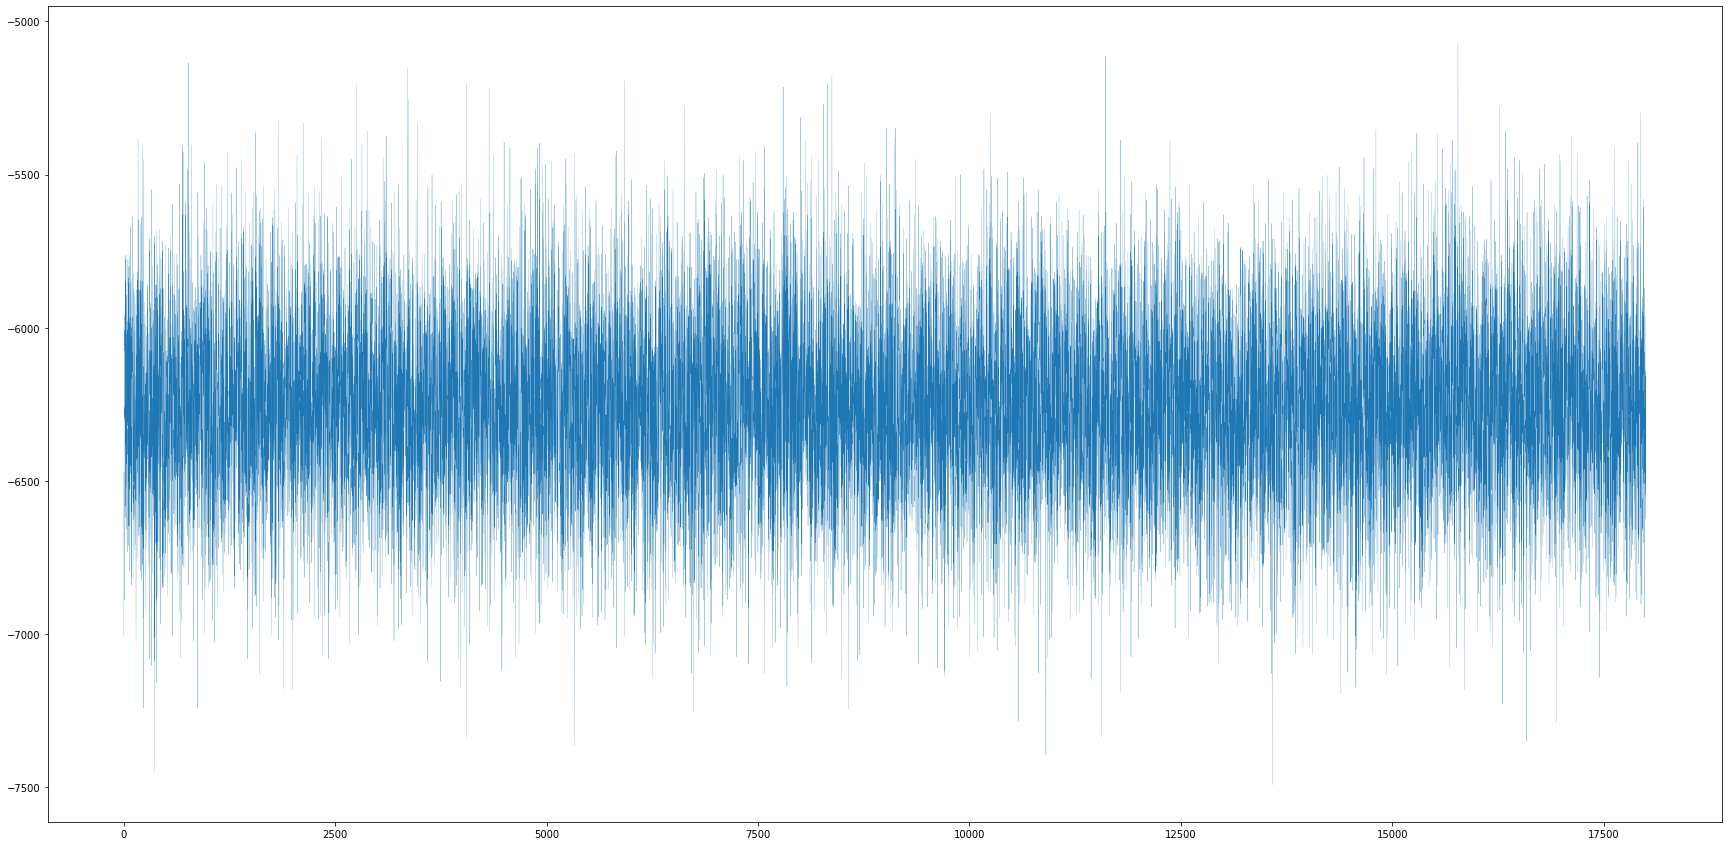

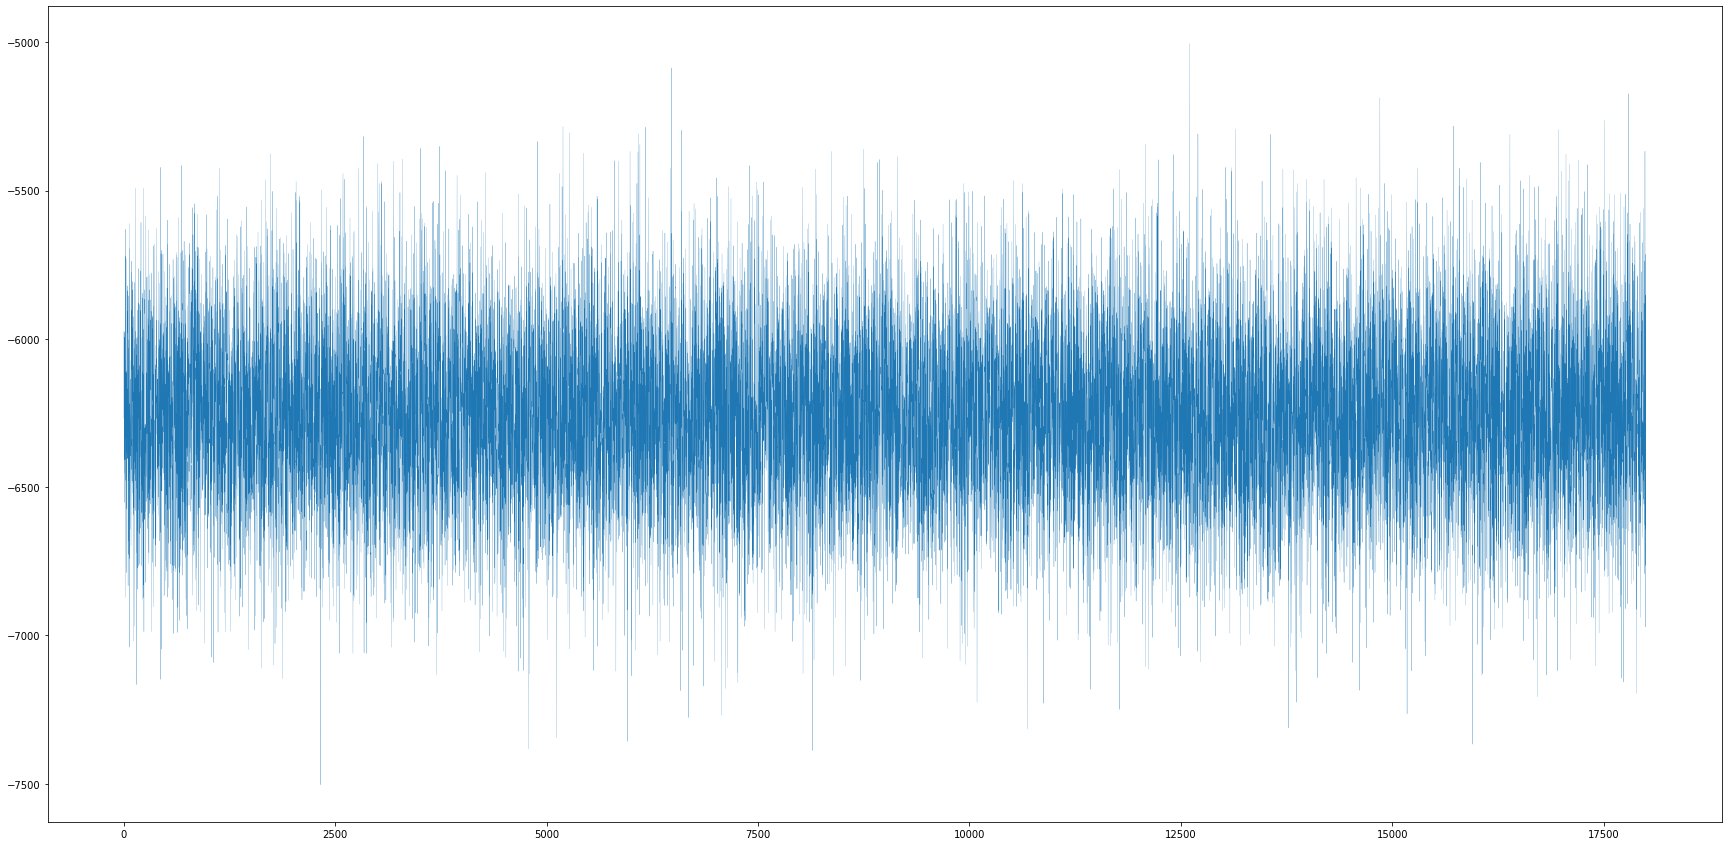

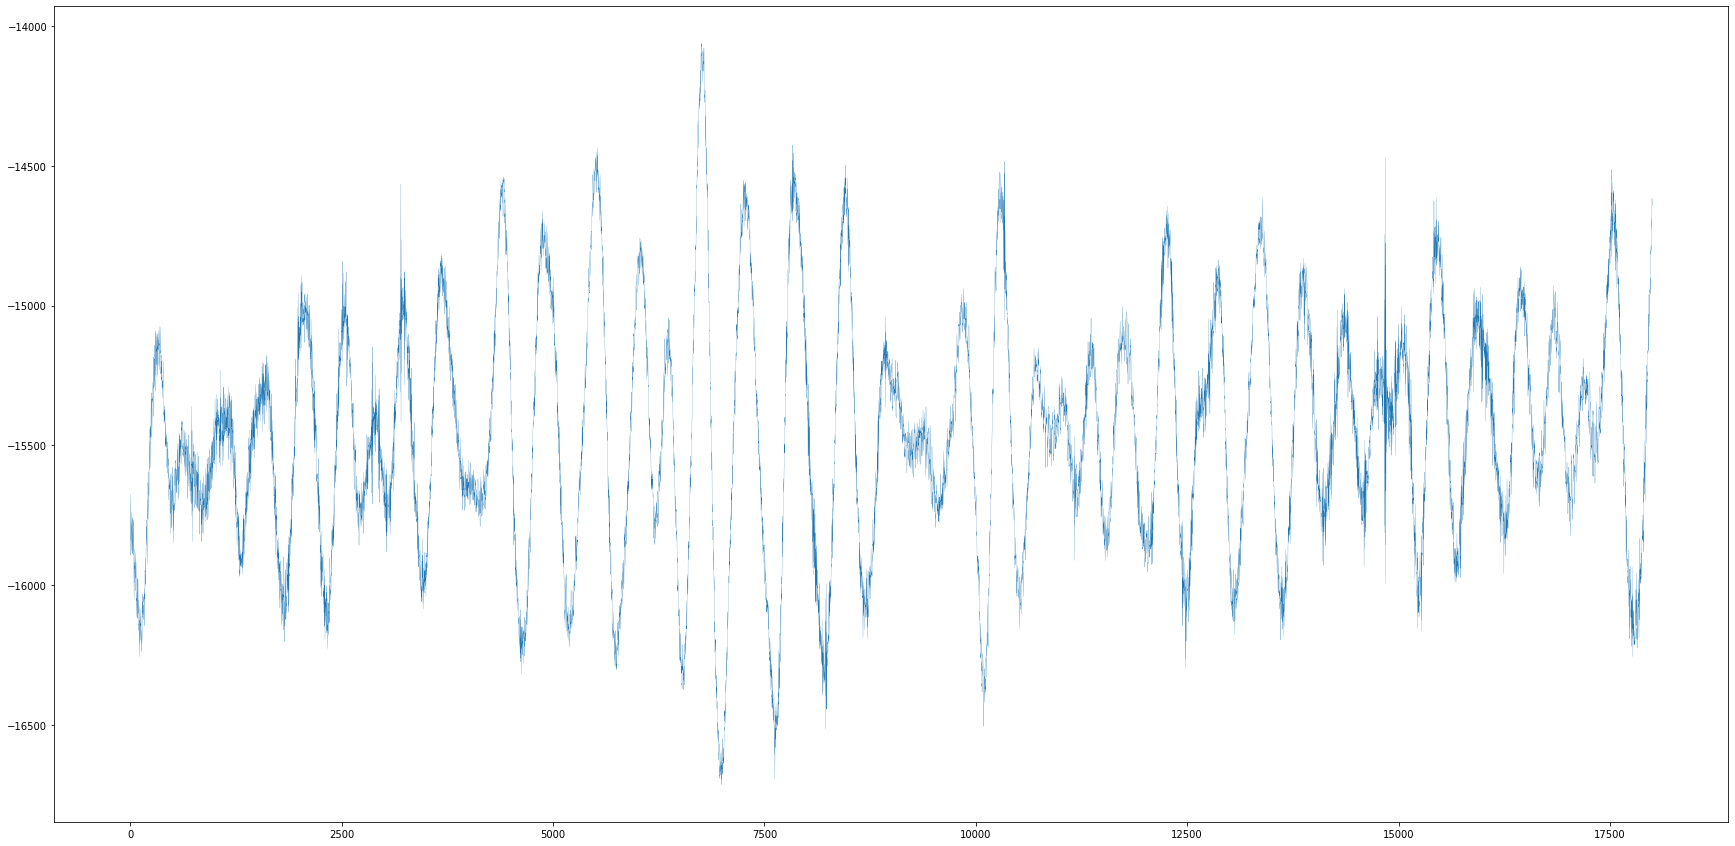

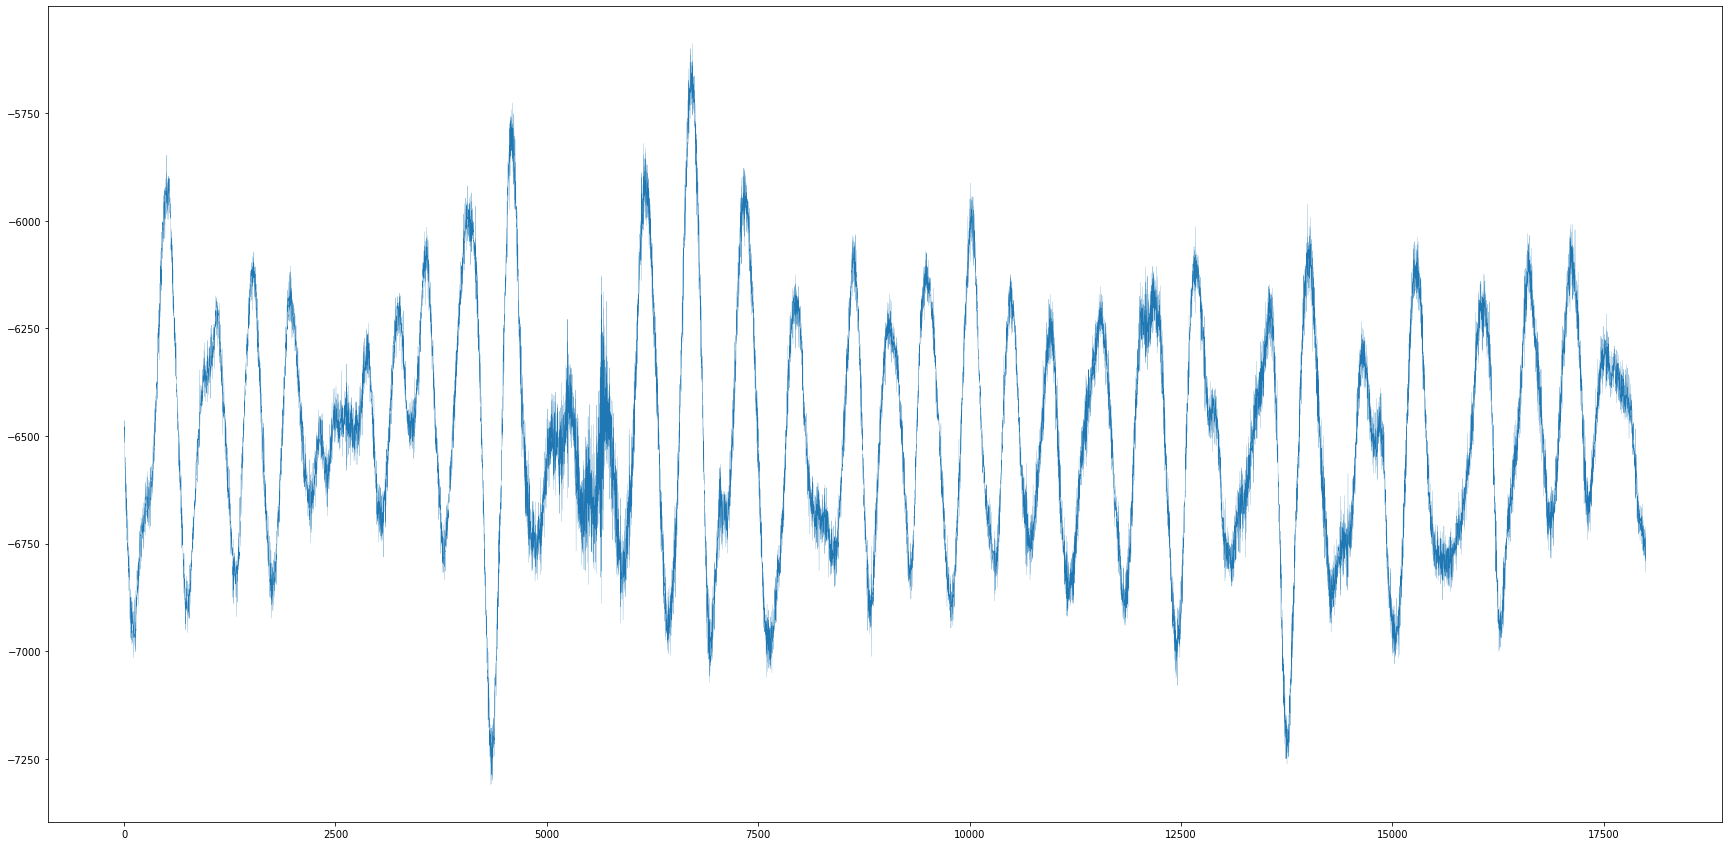

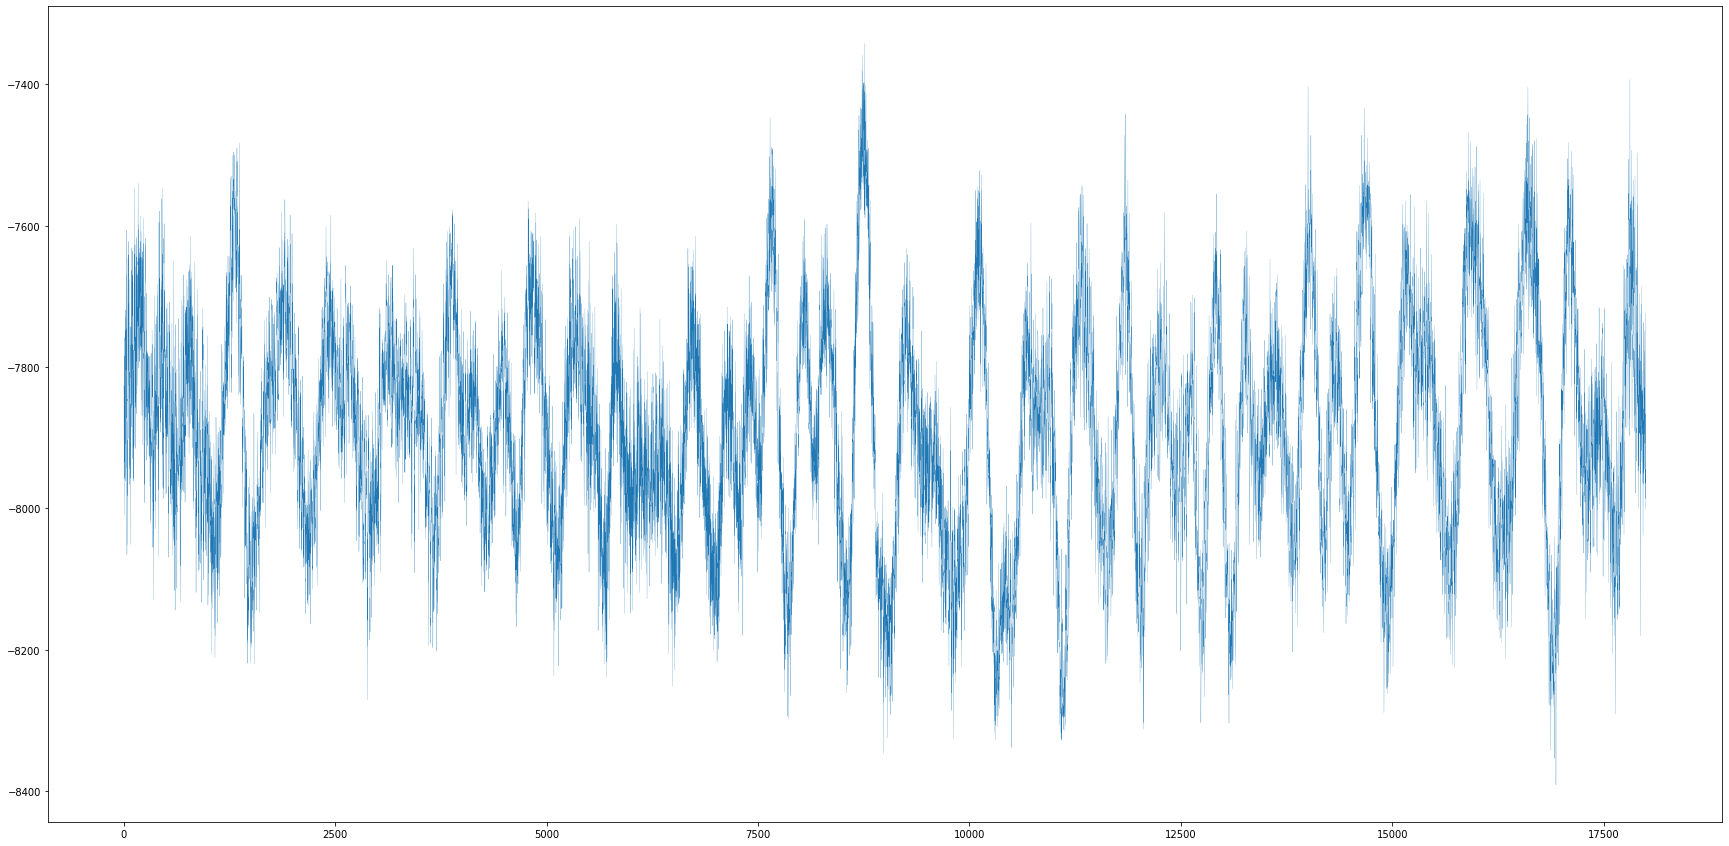

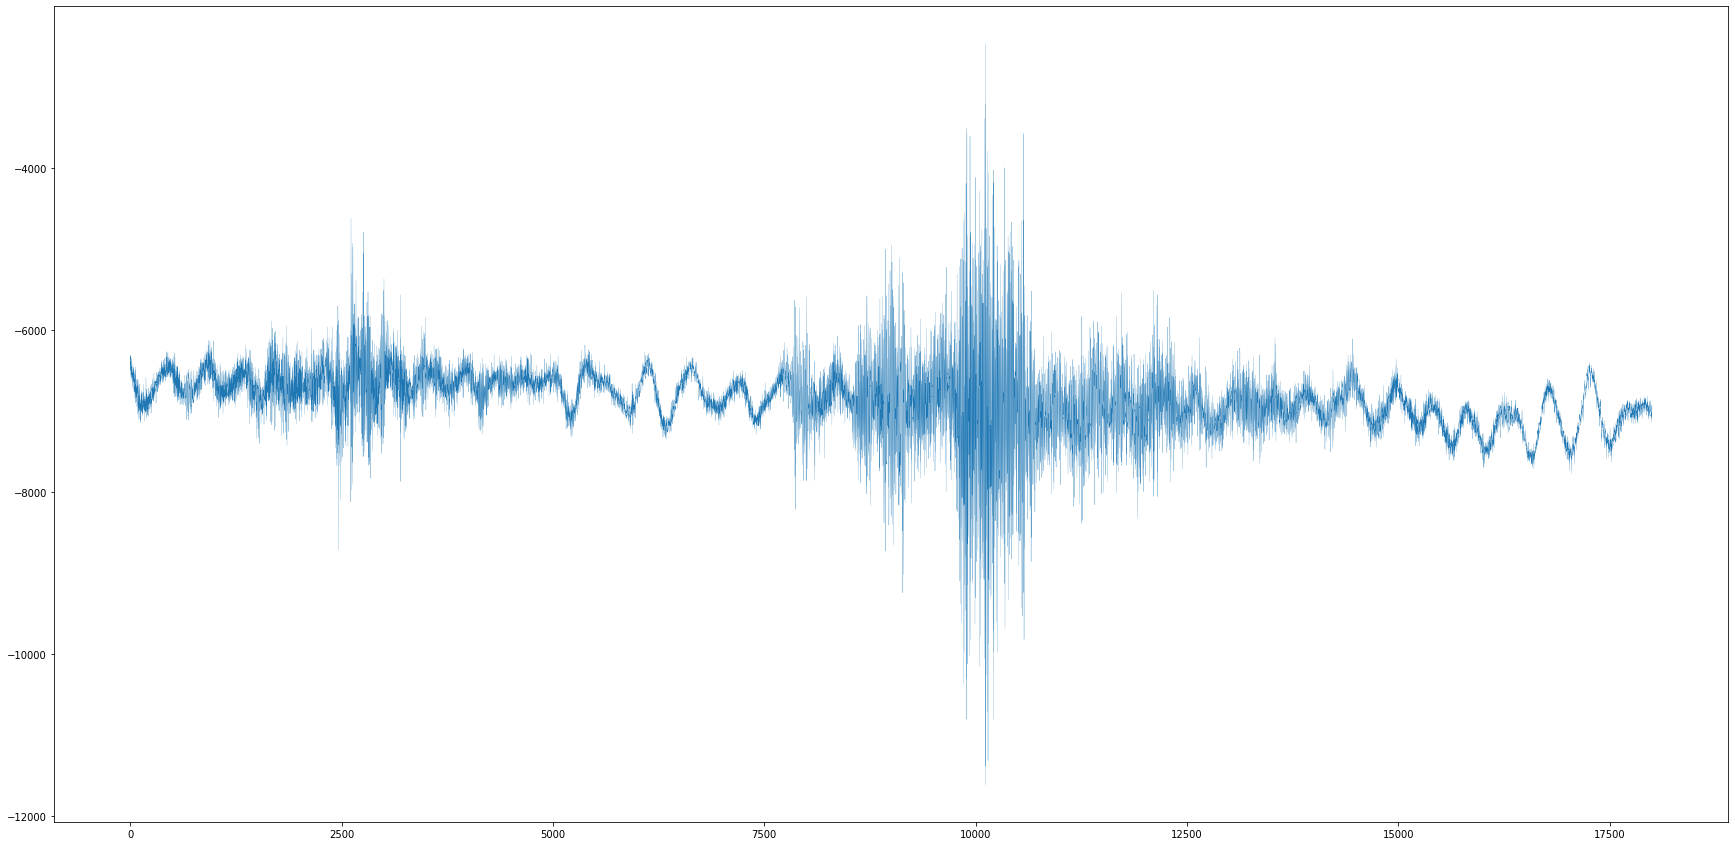

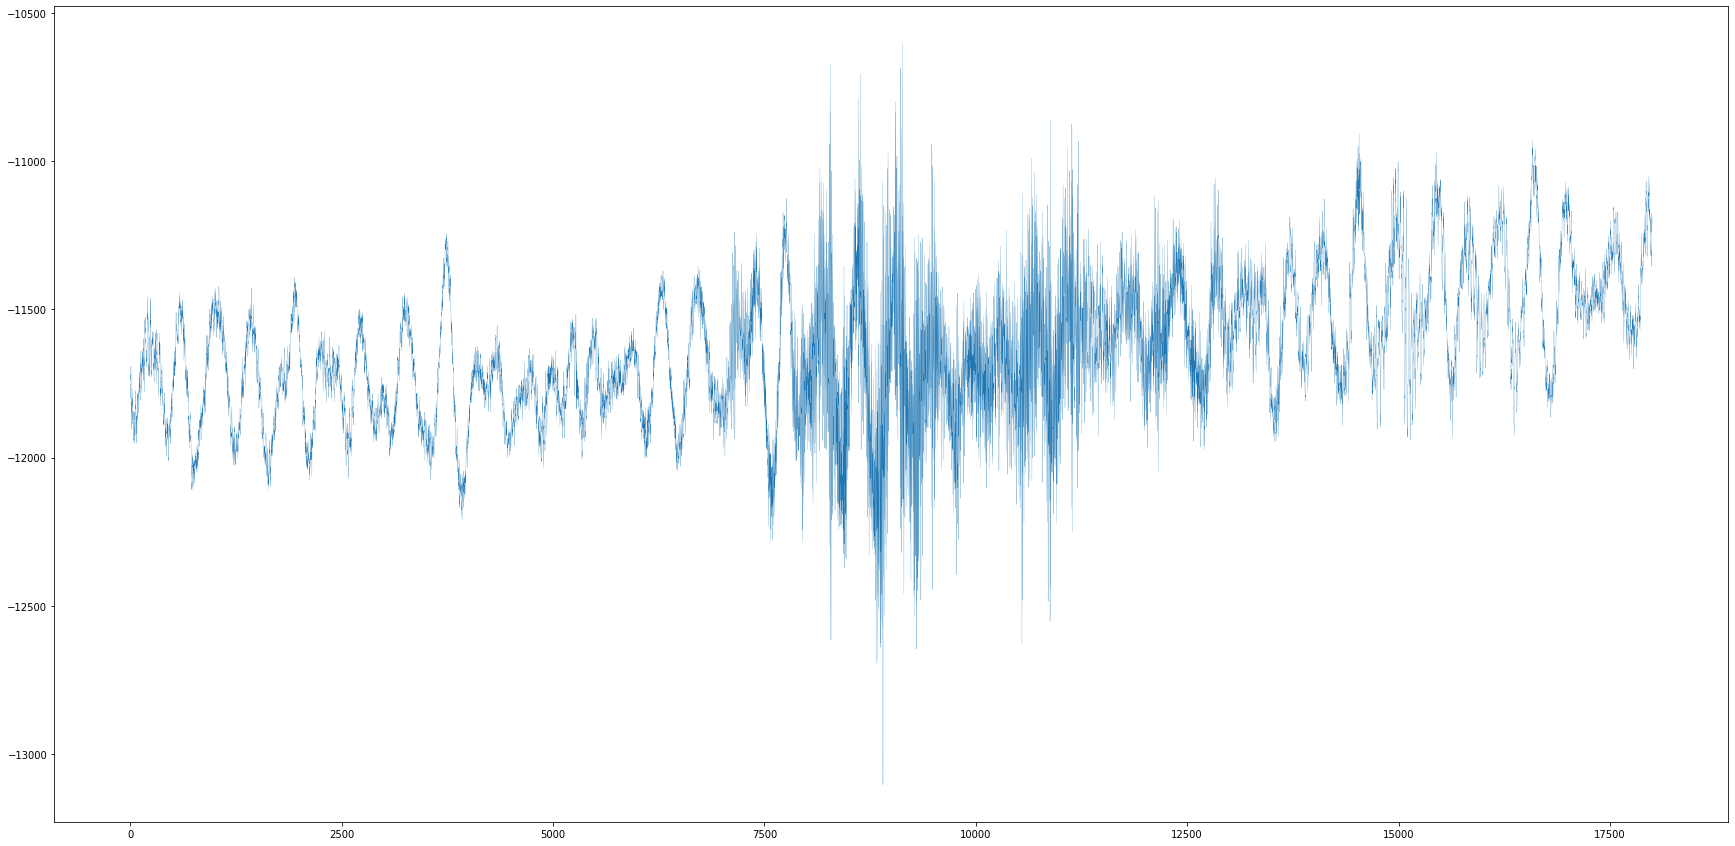

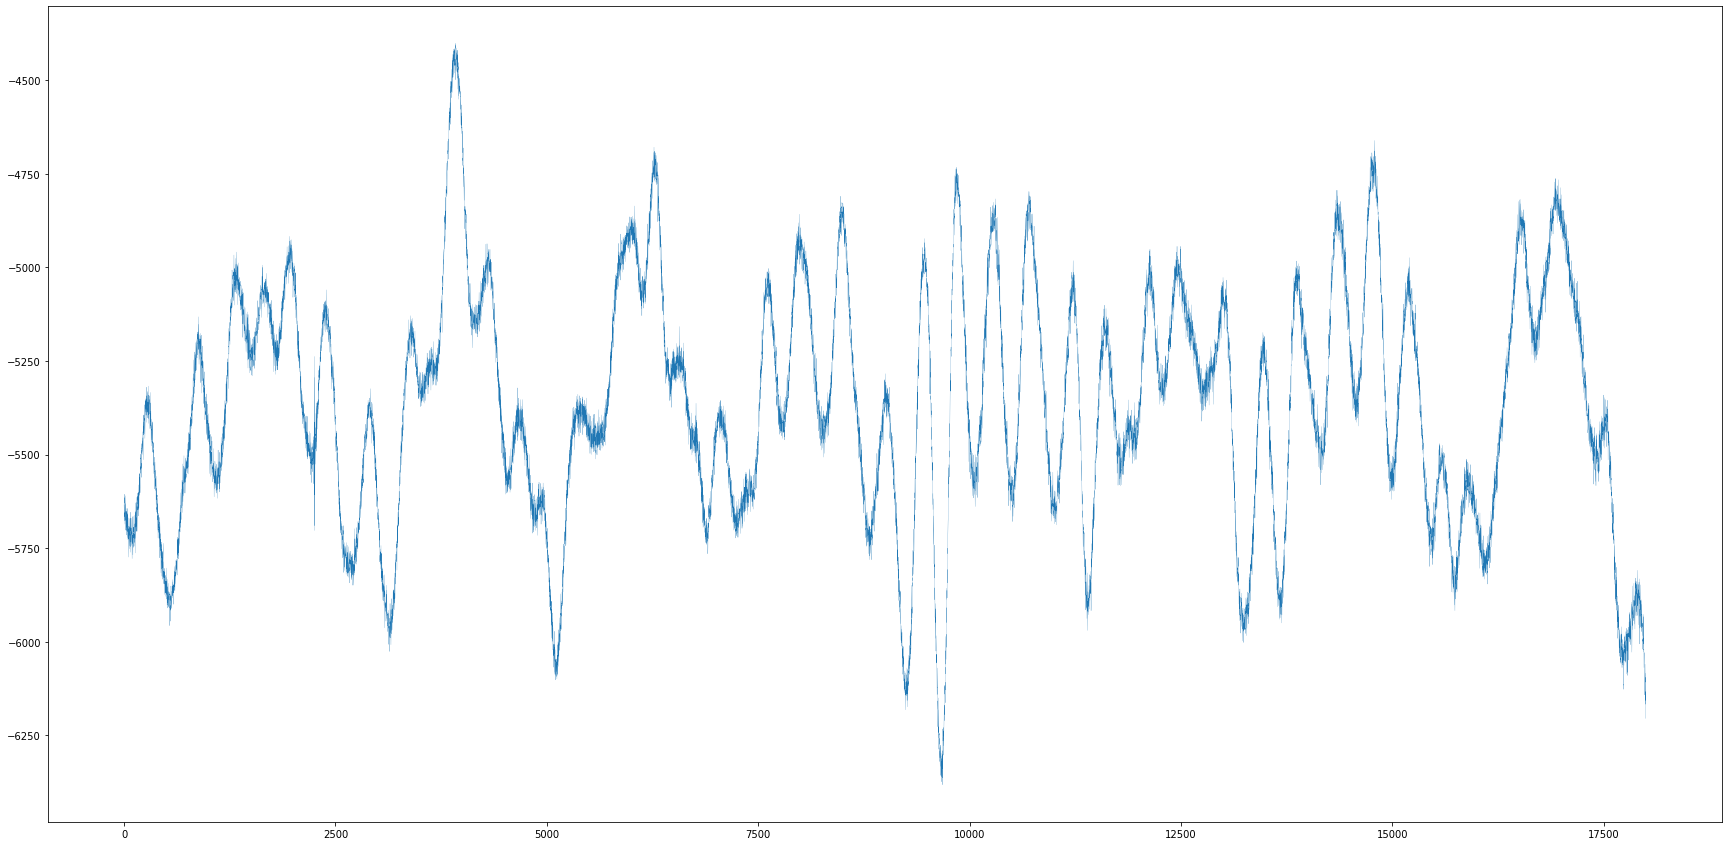

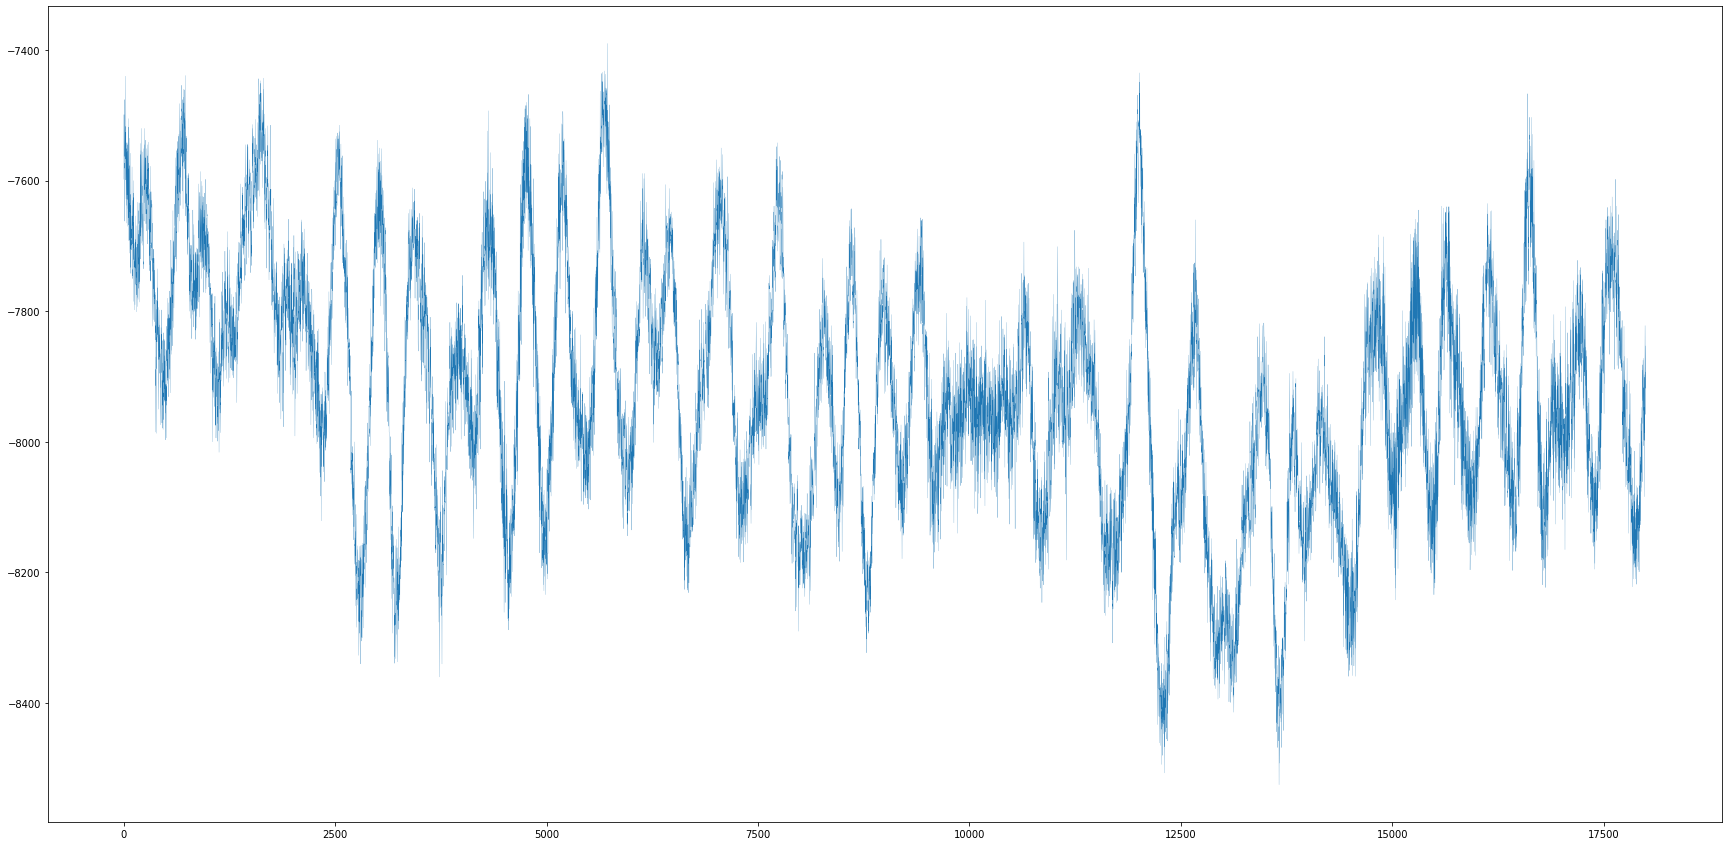

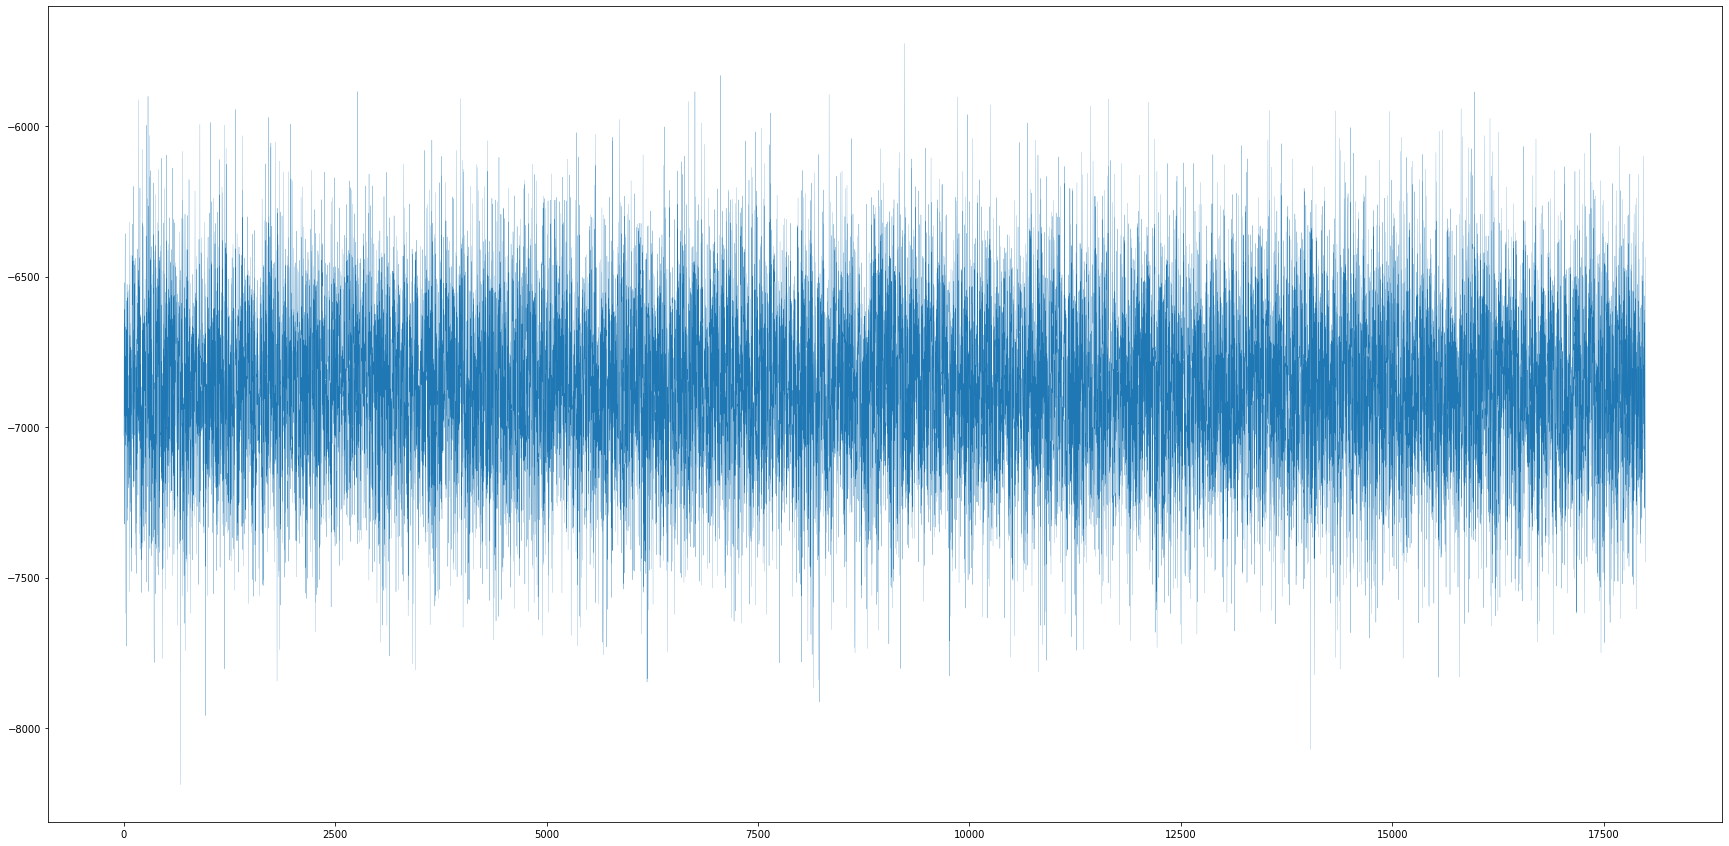

In [38]:
df_eq = pd.DataFrame()
for i in np.where(y_train == 1)[0][:10]:
    plt.figure(figsize=(30,15))
    plt.plot(raw[i-1:i+2].ravel(), linewidth=0.2)
    plt.show()

In [61]:
eq_train = pd.DataFrame(X_train[np.where(y_train==1)[0], :])
neq_train = pd.DataFrame(X_train[np.where(y_train==0)[0], :])
display(eq_train.head())
display(neq_train.head())
display(eq_train.describe())
neq_train.describe()

,0,1,2,3,4,5,6
0,6.0,0.181858,0.359707,0.481343,0.326518,0.396338,0.683400
1,9.0,0.202233,0.383896,0.650347,0.296541,2.540928,1.736583
2,5.0,0.141775,0.320387,0.423274,0.288383,0.343593,0.573366
3,82.0,0.295976,0.534883,1.048451,0.659352,1.758448,2.848242
4,361.0,0.541908,0.999125,2.098645,1.251229,3.734706,6.265487


,0,1,2,3,4,5,6
0,14.0,0.487835,0.260713,0.374550,0.300955,0.140596,0.201192
1,65.0,1.156853,0.419186,0.621367,0.581550,0.154620,0.260271
2,7.0,0.332261,0.323134,0.442165,0.326291,0.289401,0.517039
3,3.0,0.248395,0.259170,0.370344,0.292929,0.165353,0.239984
4,0.0,0.047398,0.162725,0.231451,0.149516,0.154930,0.245191


,0,1,2,3,4,5,6
count,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000
mean,217.233129,133.343488,1.140461,2.448567,1.335517,4.334892,6.462722
std,362.869118,2056.923744,2.522972,9.009437,3.357094,20.388911,29.275039
min,0.000000,0.010130,0.096023,0.141237,0.086167,0.150643,0.152973
25%,5.000000,0.131225,0.394854,0.661584,0.386707,0.764126,1.209465
50%,63.000000,0.240547,0.597450,1.001486,0.679931,1.311583,2.066278
75%,249.000000,0.547507,1.026539,1.784253,1.260485,2.438214,3.560769
max,2027.000000,65910.526316,32.335435,162.589740,55.298559,351.246608,535.419433


,0,1,2,3,4,5,6
count,85258.000000,85258.000000,85258.000000,85258.000000,85258.000000,85258.000000,85258.000000
mean,119.128962,6.483530,0.571923,0.846614,0.675137,0.949660,1.095388
std,304.520917,138.352015,0.988188,1.727115,0.848203,1.814931,2.642040
min,0.000000,0.004388,0.057651,0.112162,0.071338,0.079443,0.102748
25%,0.000000,0.067749,0.238405,0.356905,0.238813,0.324976,0.384649
50%,13.000000,0.167033,0.378758,0.589270,0.426879,0.562679,0.723168
75%,91.000000,0.344149,0.608817,0.933231,0.820412,1.229950,1.407455
max,7130.000000,14327.272727,65.000138,127.027393,30.119493,134.307396,211.243413


In [22]:
earthquake_times = time_stamps[y_train == 1]
earthquake_indices = np.where(y_train == 1)[0]
not_earthquake_times = time_stamps[y_train == -1]
not_earthquake_indices =  np.where(y_train == -1)[0]

In [23]:
time_hq = pd.to_datetime("2018-04-09 10:22:18")
second_to_hq = (time_hq - start_time_train).total_seconds()

time_window_hq = X_train[int(second_to_hq * SPS): int(second_to_hq * SPS) + spw]
time_window_hq = time_window_hq - np.mean(time_window_hq)

/home/lulu/.venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lulu/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


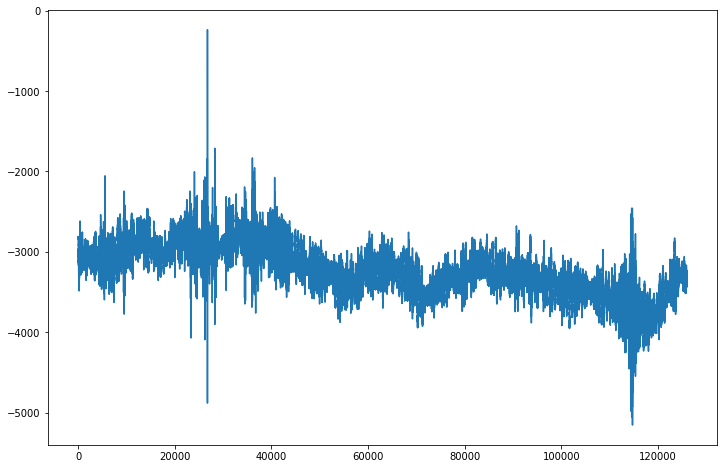

In [31]:
#X_raw = pd.read_hdf('../processed-data/new/raw_X_train_1_to_4_with_basic.hdf')
plt.figure(figsize=(12,8))
plt.plot(X_raw.loc[:20].to_numpy().reshape(-1))

In [31]:
X_train_plot = X_train[:X_train_raw.shape[0]]
y_train_plot = y_train[:X_train_raw.shape[0]]

def plot_alt(data_index):
    time_window = X_train_raw[data_index]
    print("Features: ", X_train[data_index])
    print("Date: ", times_plot[data_index])
    
    #earthquake_times = catalog_train["origintime"][(catalog_train["origintime"] >= date) &\
    #                                              (catalog_train["origintime"] <= pd.to_datetime(date + pd.to_timedelta(TIME_WINDOW, unit='s')))]
    
    # Number of samplepoints
    N = 6000

    # sample spacing
    T = 1.0 / 200

    x = np.arange(np.shape(time_window)[0])
    y = time_window - np.mean(time_window)

    xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
    yf = np.fft.fft(y)
    y_amplitudes = 2.0/N * np.abs(yf[:N//2])

    _, axs = plt.subplots(ncols=2, figsize=(20,8))
    #title = "Earthquake time window" if earthquake else "Not earthquake time window"
    #plt.suptitle(title, fontsize=18)
    
    # Plot time
    axs[0].plot(x, y)
   # for eq_time in earthquake_times.values:
   #     second = (eq_time - date) / np.timedelta64(1,'s') * SPS
   #     axs[0].axvline(second, color='r')
    axs[0].set_title("Time plot for time window", fontsize=18)
    axs[0].set_xlabel("Time", fontsize=13)
    axs[0].set_ylabel("Value", fontsize=13)
    
    # Plot frequency
    yf = 2.0/N * np.abs(yf[:N//2])
    
    axs[1].plot(xf, yf)
    axs[1].set_title("FFT plot for time window", fontsize=18)
    axs[1].set_xlabel("Frequency", fontsize=13)
    axs[1].set_ylabel("Amplitude", fontsize=13)
    
    plt.show() 
print("Not earthquake")
plot_alt(np.random.choice(np.where(y_train_plot == 0)[0]))
print("Earthquake")
plot_alt(np.random.choice(np.where(y_train_plot ==1)[0]))

Not earthquake
Features:  [  5.70210000e+04   0.00000000e+00   3.12278589e-02   5.10912338e-02
   7.15702042e-02   1.54231688e-01   7.39395978e-02   8.23972063e-02]


NameError: name 'times_plot' is not defined

In [110]:
y_train_plot.shape

(86399,)

In [105]:
np.random.choice(np.where(y_train == 0)[0])

44063

In [93]:
def get_window_timestamp(date):
    seconds_to_hq = (pd.to_datetime(date) - start_time_train).total_seconds()
    
    time_window = X_train[int(seconds_to_hq * SPS / spw), :]
    
    return time_window

def plot_window_time_and_fft(data_index, date, earthquake):
    time_window = X_train_raw[data_index]
    print("Features: ", X_train[data_index])
    print("Date: ", date)
    
    earthquake_times = catalog_train["origintime"][(catalog_train["origintime"] >= date) &\
                                                   (catalog_train["origintime"] <= pd.to_datetime(date + pd.to_timedelta(TIME_WINDOW, unit='s')))]
    
    # Number of samplepoints
    N = 6000

    # sample spacing
    T = 1.0 / 200

    x = np.arange(np.shape(time_window)[0])
    y = time_window - np.mean(time_window)

    xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
    yf = np.fft.fft(y)
    y_amplitudes = 2.0/N * np.abs(yf[:N//2])

    _, axs = plt.subplots(ncols=2, figsize=(20,8))
    title = "Earthquake time window" if earthquake else "Not earthquake time window"
    plt.suptitle(title, fontsize=18)
    
    # Plot time
    axs[0].plot(x, y)
    for eq_time in earthquake_times.values:
        second = (eq_time - date) / np.timedelta64(1,'s') * SPS
        axs[0].axvline(second, color='r')
    axs[0].set_title("Time plot for time window", fontsize=18)
    axs[0].set_xlabel("Time", fontsize=13)
    axs[0].set_ylabel("Value", fontsize=13)
    
    # Plot frequency
    yf = 2.0/N * np.abs(yf[:N//2])
    
    axs[1].plot(xf, yf)
    axs[1].set_title("FFT plot for time window", fontsize=18)
    axs[1].set_xlabel("Frequency", fontsize=13)
    axs[1].set_ylabel("Amplitude", fontsize=13)
    
    plt.show() 

In [25]:
earthquake_indices

array([  20,  180,  188,  196,  207,  221,  251,  281,  372,  384,  397,
        410,  429,  819,  906,  913,  926, 1030, 1188, 1192, 1238, 1320,
       1422, 1432, 1471, 1534, 1576, 1717, 1844, 1918])

Features:  [ 209.            0.42583682   42.03334942   55.64337809   25.69480258
  181.98554261  107.7716021 ]
Date:  2018-04-09T18:36:00.000000000


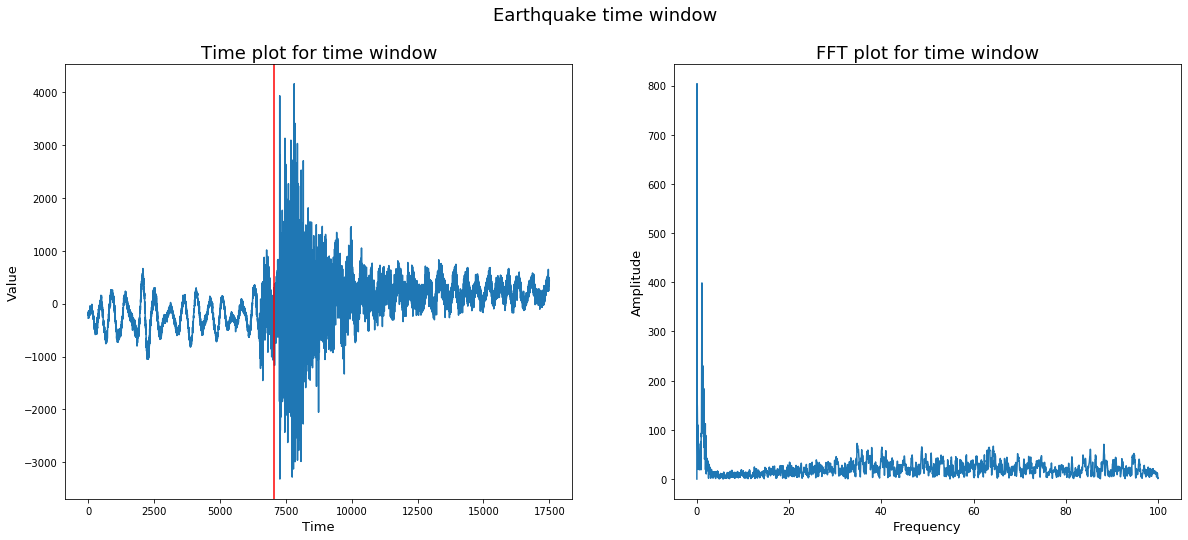

Features:  [  0.00000000e+00   5.96498987e-02   5.67974728e+00   1.62367363e+01
   2.93195213e+00   2.07002138e+02   8.88667881e+01]
Date:  2018-04-11T08:12:00.000000000


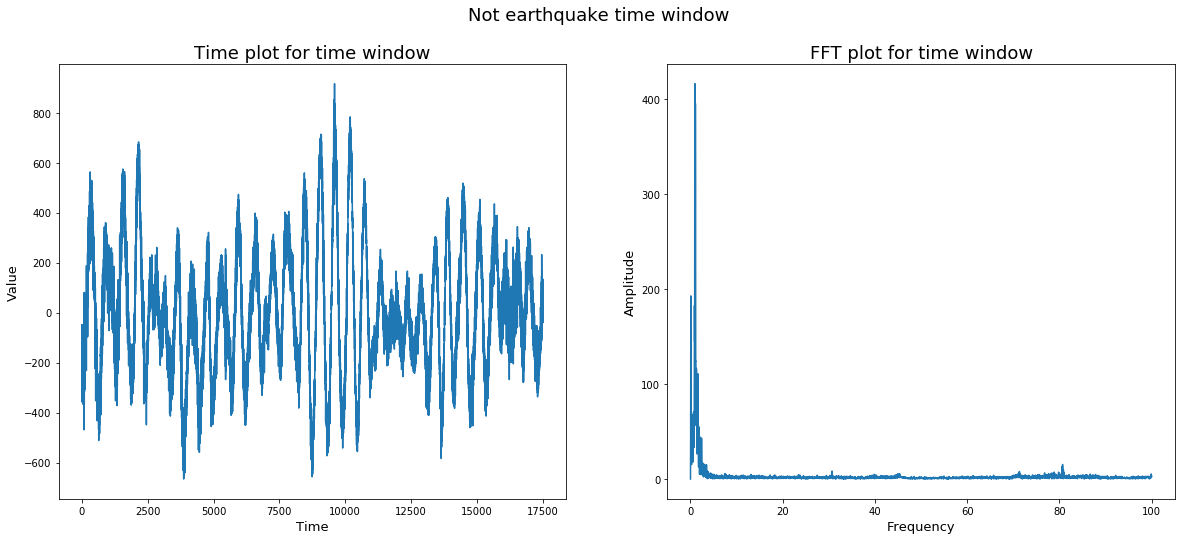

Features:  [  48.            0.38766847   16.09838251   31.19296187   16.5315553
  154.54030322   83.66036919]
Date:  2018-04-09T09:00:00.000000000


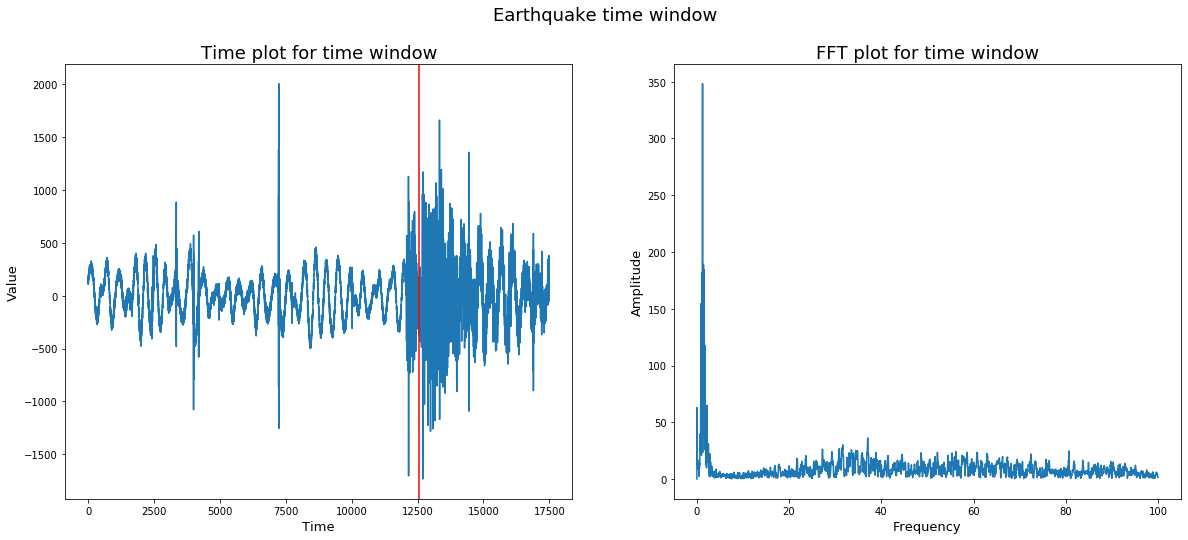

Features:  [ 188.            0.45322516   12.62822961   19.01159194   11.76716593
   67.52032421   44.49966131]
Date:  2018-04-12T21:33:00.000000000


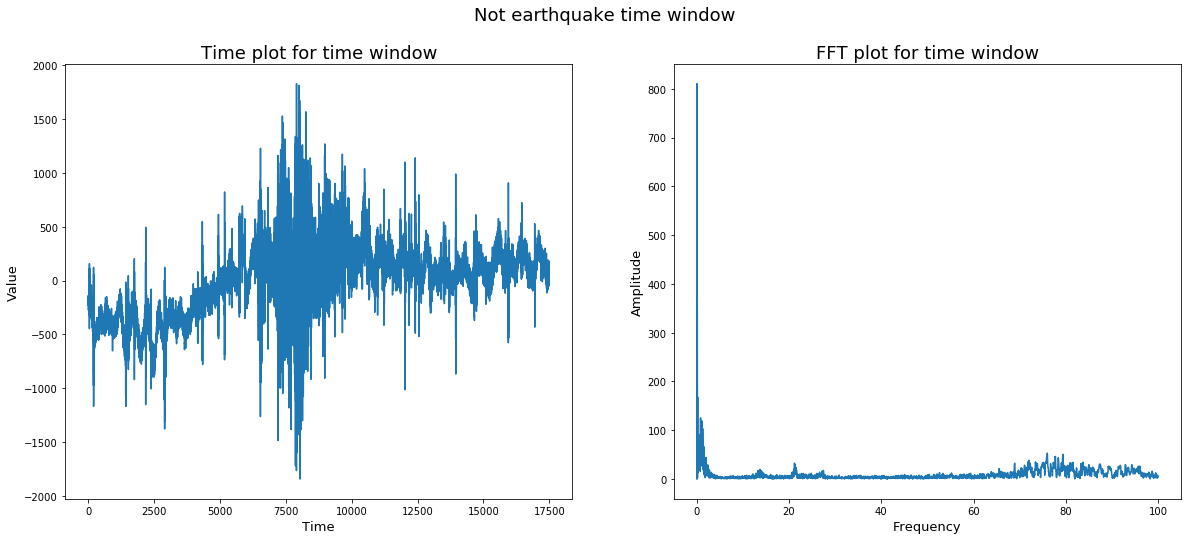

Features:  [  73.            0.32466295   10.22799125   21.3792587     5.72062287
  216.99557834   90.04468205]
Date:  2018-04-11T11:24:00.000000000


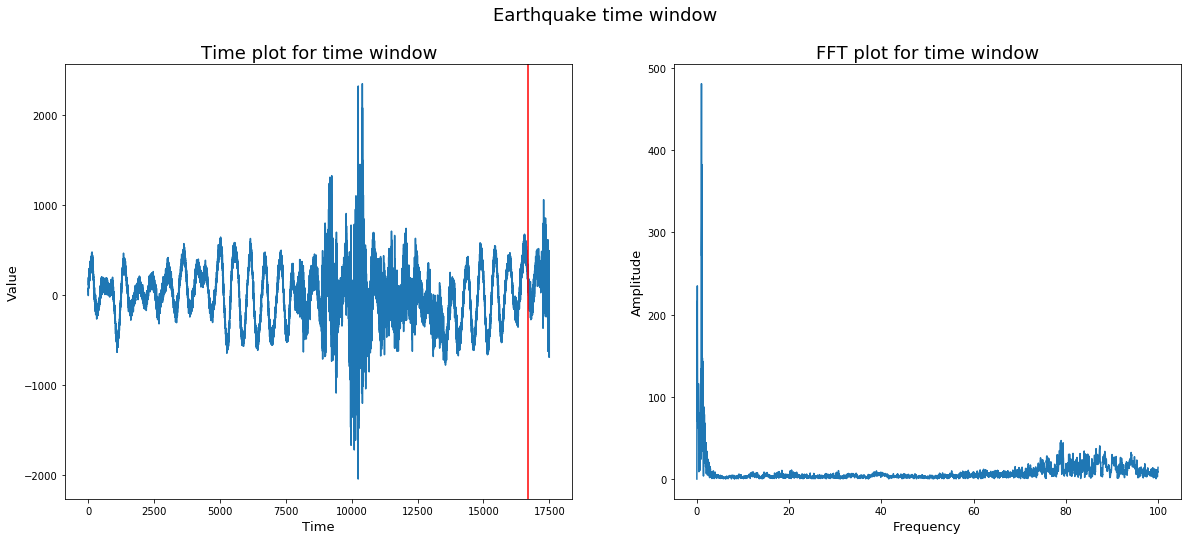

Features:  [  86.            0.19352195   13.90152397   28.66091471    7.08200521
  188.22503387  106.5786264 ]
Date:  2018-04-09T18:54:00.000000000


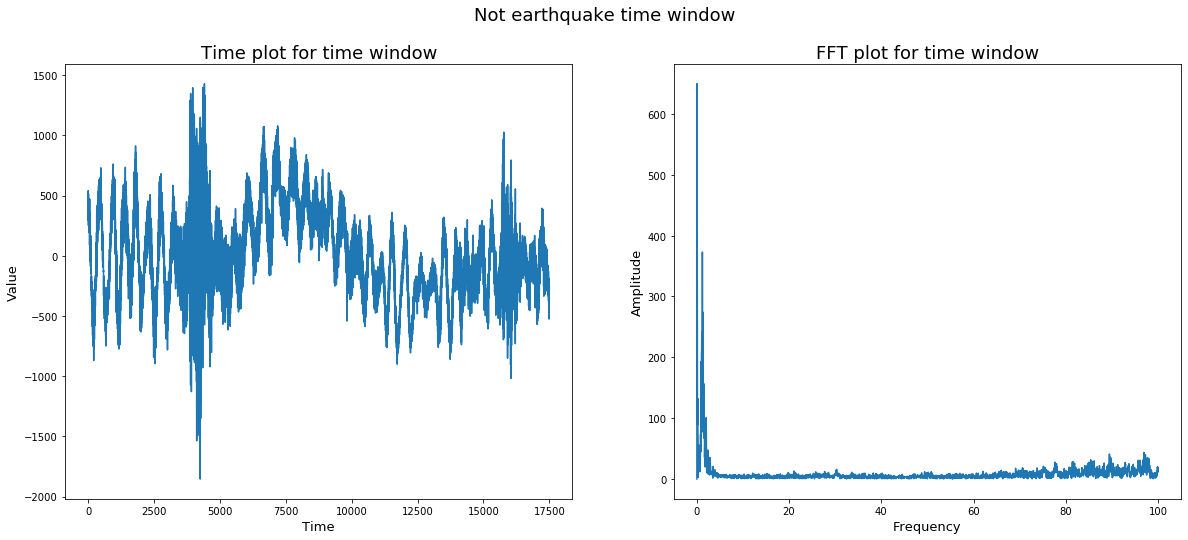

Features:  [ 433.            3.20083843  118.30015051  137.59846448   95.12691057
   82.45791484  113.76669836]
Date:  2018-04-12T01:33:00.000000000


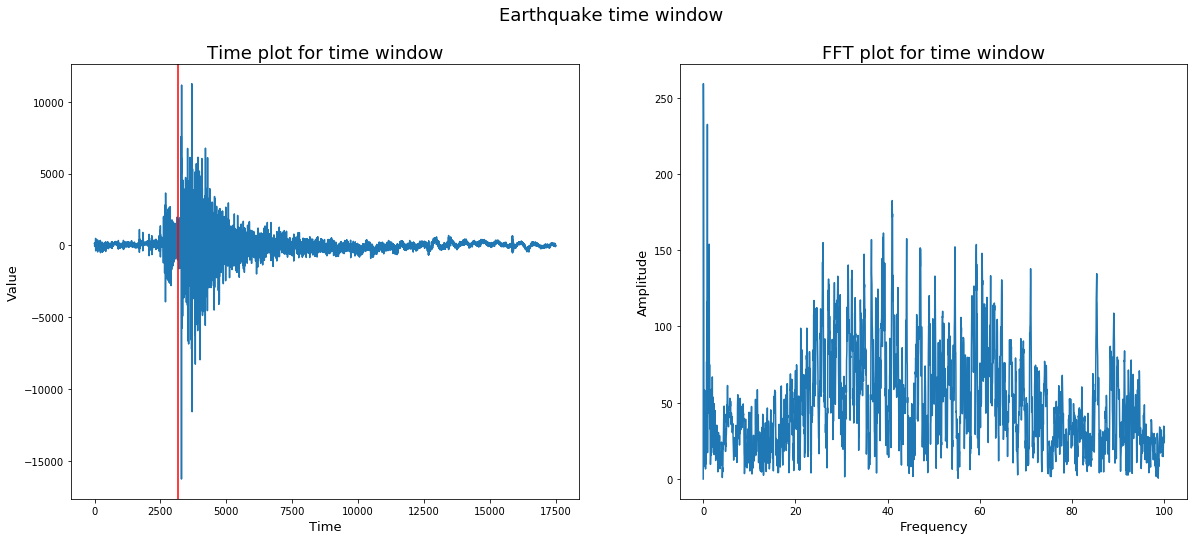

Features:  [  0.00000000e+00   7.14097734e-02   4.84019265e+00   1.06113175e+01
   2.79578843e+00   8.58250122e+01   4.67050072e+01]
Date:  2018-04-12T06:09:00.000000000


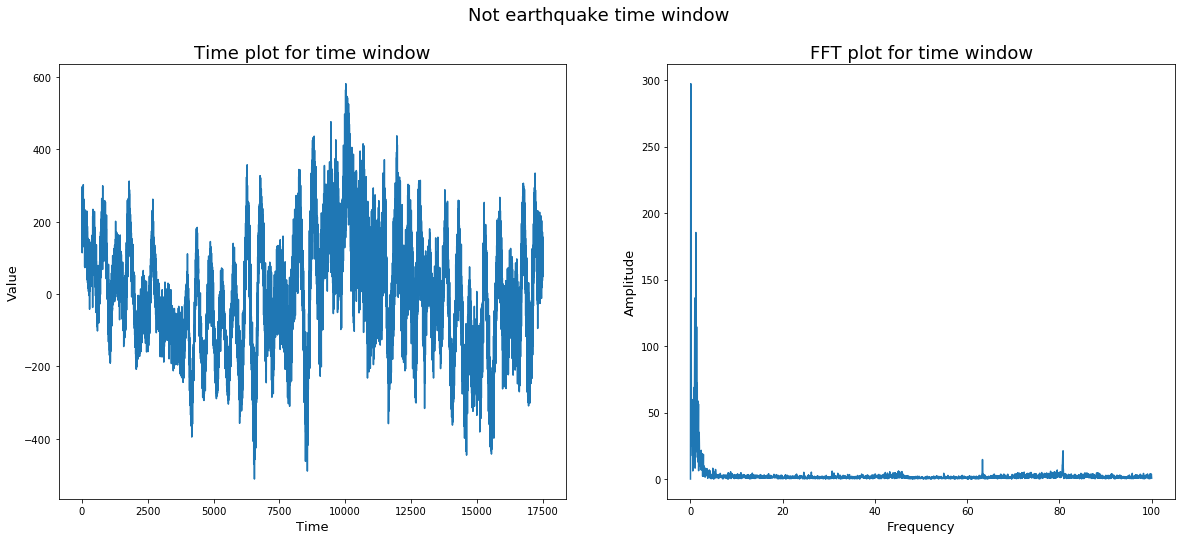

In [26]:
nm_plots = 4

eqs = np.random.choice(len(earthquake_times), nm_plots, replace=True)
not_eqs = np.random.choice(len(not_earthquake_times), nm_plots, replace=False)

stats = pd.DataFrame()
for i, (eq, not_eq) in enumerate(list(zip(eqs, not_eqs))):
    plot_window_time_and_fft(earthquake_indices[eq], earthquake_times[eq], True)
    plot_window_time_and_fft(not_earthquake_indices[not_eq], not_earthquake_times[not_eq], False)